In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.ticker import MaxNLocator
from pathlib import Path

import torch
import torch.nn.functional as Fun
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.datasets import QM9
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

In [2]:
import sys
if sys.platform.startswith(("linux", "darwin")):
    !mamba install -q -y -c pyg pyg

In [2]:
# specify the local data path
HERE = Path("./data")
DATA = HERE 

In [3]:
# load dataset
qm9 = QM9(root=DATA)

In [5]:
len(qm9.data.y)
qm9[10000].y

c:\Users\friha\.conda\envs\NetSci\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


tensor([[ 3.0178e+00,  6.7000e+01, -6.8518e+00, -8.8981e-01,  5.9620e+00,
          1.0346e+03,  3.4614e+00, -1.0442e+04, -1.0441e+04, -1.0441e+04,
         -1.0443e+04,  3.2217e+01, -6.8336e+01, -6.8706e+01, -6.9092e+01,
         -6.3758e+01,  2.4398e+00,  1.8664e+00,  1.1283e+00]])


# QM9 Dataset Exploration
# 
### The QM9 dataset contains 133,885 small organic molecules with up to 9 heavy atoms (C, O, N, F). Each molecule has:
### - Quantum chemical properties
### - 3D atomic coordinates
### - Molecular graph structure (nodes = atoms, edges = bonds)


In [9]:
from rdkit import Chem
from rdkit.Chem import Draw
import py3Dmol

In [21]:
# Load dataset
dataset = QM9(root=DATA)
data = dataset[17]  # Get first molecule

#  Dataset Overview
### Each entry contains:
### - Node features (atom types)
### - Edge indices (molecular connections)
### - Edge attributes (bond types + distances)
### - 3D coordinates
### - 19 target properties
### - SMILES representation

In [12]:
# Basic data inspection
print("Data object:", data)
print("\nKey components:")
print(f"Number of nodes (atoms): {data.num_nodes}")
print(f"Node features shape: {data.x.shape} [nodes x atom features]")
print(f"Edge indices shape: {data.edge_index.shape} [2 x edges]")
print(f"Edge attributes shape: {data.edge_attr.shape} [edges x bond features]")
print(f"3D positions shape: {data.pos.shape} [nodes x 3D coordinates]")
print(f"Target properties (19): {data.y.shape}")

Data object: Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], z=[5], smiles='[H]C([H])([H])[H]', name='gdb_1', idx=[1])

Key components:
Number of nodes (atoms): 5
Node features shape: torch.Size([5, 11]) [nodes x atom features]
Edge indices shape: torch.Size([2, 8]) [2 x edges]
Edge attributes shape: torch.Size([8, 4]) [edges x bond features]
3D positions shape: torch.Size([5, 3]) [nodes x 3D coordinates]
Target properties (19): torch.Size([1, 19])


## Node Features (Atom Types)
### One-hot encoded features for atomic numbers:
### - Index 0: Hydrogen (H)
### - Index 1: Carbon (C)
### - Index 2: Nitrogen (N)
### - Index 3: Oxygen (O)
### - Index 4: Fluorine (F)

In [13]:
# Correct node feature inspection
atom_types = ['H', 'C', 'N', 'O', 'F']
print("\nNode features for first 5 atoms:")
for i in range(min(5, data.num_nodes)):  # Safer boundary check
    features = data.x[i]
    atom_idx = torch.argmax(features[:5]).item()  # Only consider first 5 dimensions
    atom_props = {
        'atomic_number': features[5].item(),
        'charge': features[6].item(),
        'mass': features[7].item(),
        'vdw_radius': features[8].item(),
        'electronegativity': features[9].item(),
        'aromatic': bool(features[10].item())
    }
    
    print(f"Atom {i+1}: {atom_types[atom_idx]}")
    print(f"Properties: {atom_props}\n")
    print(f"{features}")


Node features for first 5 atoms:
Atom 1: C
Properties: {'atomic_number': 6.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': True}

tensor([0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.])
Atom 2: H
Properties: {'atomic_number': 1.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': False}

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Atom 3: H
Properties: {'atomic_number': 1.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': False}

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Atom 4: H
Properties: {'atomic_number': 1.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': False}

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
Atom 5: H
Properties: {'atomic_number': 1.0, 'charge': 0.0, 'mass': 0.0, 'vdw_radius': 0.0, 'electronegativity': 0.0, 'aromatic': False}

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])


## Edge Attributes (Bond Information)
### Each edge has:
### - Bond type (1.0=Single, 1.5=Aromatic, 2.0=Double, 3.0=Triple)
### - Bond length (Angstroms)


In [14]:
# Correct edge attribute inspection
bond_type_map = {1.0: 'Single', 1.5: 'Aromatic', 2.0: 'Double', 3.0: 'Triple'}
print("\nFirst 5 edge attributes:")
for i in range(min(5, data.edge_attr.shape[0])):
    attr = data.edge_attr[i]
    print(f"Edge {i+1}:")
    print(f"  Bond type: {bond_type_map.get(attr[0].item(), 'Unknown')}")
    print(f"  Distance: {attr[1].item():.3f} Å")
    print(f"  Same ring: {bool(attr[2].item())}")
    print(f"  Conjugated: {bool(attr[3].item())}\n")


First 5 edge attributes:
Edge 1:
  Bond type: Single
  Distance: 0.000 Å
  Same ring: False
  Conjugated: False

Edge 2:
  Bond type: Single
  Distance: 0.000 Å
  Same ring: False
  Conjugated: False

Edge 3:
  Bond type: Single
  Distance: 0.000 Å
  Same ring: False
  Conjugated: False

Edge 4:
  Bond type: Single
  Distance: 0.000 Å
  Same ring: False
  Conjugated: False

Edge 5:
  Bond type: Single
  Distance: 0.000 Å
  Same ring: False
  Conjugated: False



## Molecular Visualization
### 2D structure from SMILES and 3D coordinates visualization


In [28]:
data = dataset[19]

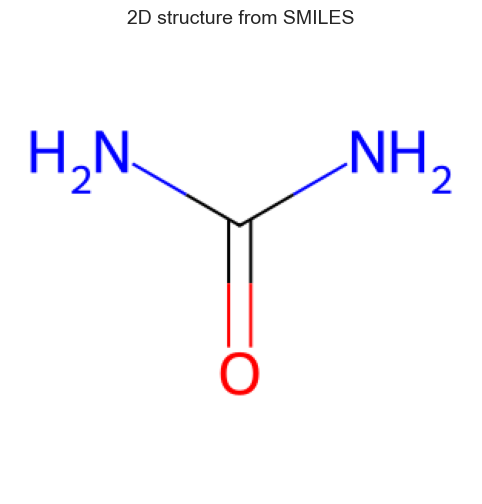

In [31]:
# 2D structure using SMILES
mol = Chem.MolFromSmiles(data.smiles)
img = Draw.MolToImage(mol, size=(300, 300))
plt.imshow(img)
plt.axis('off')
plt.title('2D structure from SMILES')
plt.show()

In [33]:
# 3D visualization using atomic coordinates
# Corrected 3D visualization with type conversion
# Enhanced 3D visualization with bond detection
def visualize_3d_structure(pos, atom_types, edge_index):
    viewer = py3Dmol.view(width=500, height=400)
    
    atom_colors = {
        0: 'white',  # H
        1: 'gray',   # C
        2: 'blue',   # N
        3: 'red',    # O
        4: 'green'   # F
    }
    
    # Add atoms
    for i, (x, y, z) in enumerate(pos):
        viewer.addSphere({
            'center': {'x': float(x), 'y': float(y), 'z': float(z)},
            'radius': 0.5,
            'color': atom_colors.get(int(atom_types[i]), 'pink')
        })
    
    # Add bonds using edge_index
    for i in range(edge_index.shape[1]):
        src = edge_index[0, i].item()
        dst = edge_index[1, i].item()
        start = pos[src].tolist()
        end = pos[dst].tolist()
        
        viewer.addCylinder({
            'start': {'x': start[0], 'y': start[1], 'z': start[2]},
            'end': {'x': end[0], 'y': end[1], 'z': end[2]},
            'radius': 0.15,
            'color': 'black'
        })
    
    viewer.setStyle({'stick': {}})
    viewer.zoomTo()
    return viewer.show()

# Convert atom types safely
atom_indices = torch.argmax(data.x[:, :5], dim=1).numpy().astype(int)

visualize_3d_structure(data.pos.numpy(), atom_indices, data.edge_index.numpy())


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Target Property Analysis
### Quantum chemical properties at DFT level

In [18]:
# Enhanced property display with units
property_info = [
    ('Dipole moment', 'μ', 'Debye'),
    ('Isotropic polarizability', 'α', 'a.u.'),
    ('HOMO energy', 'ε_HOMO', 'eV'),
    ('LUMO energy', 'ε_LUMO', 'eV'),
    ('HOMO-LUMO gap', 'Δε', 'eV'),
    ('Electronic spatial extent', '<R²>', 'a.u.'),
    ('Zero-point vibrational energy', 'ZPVE', 'eV'),
    ('Internal energy (0K)', 'U(0K)', 'eV'),
    ('Internal energy (298K)', 'U(298K)', 'eV'),
    ('Enthalpy (298K)', 'H(298K)', 'eV'),
    ('Free energy (298K)', 'G(298K)', 'eV'),
    ('Heat capacity', 'Cv', 'cal/(mol·K)'),
    ('Atomization energy (U0)', 'U0', 'eV'),
    ('Atomization energy (U)', 'U', 'eV'),
    ('Atomization enthalpy', 'H', 'eV'),
    ('Atomization free energy', 'G', 'eV'),
    ('Rotational constant A', 'A', 'GHz'),
    ('Rotational constant B', 'B', 'GHz'),
    ('Rotational constant C', 'C', 'GHz')
]

print("\nQuantum Chemical Properties:")
for idx, (name, symbol, unit) in enumerate(property_info):
    value = data.y[0, idx].item()
    print(f"{idx:2d}. {name:<25} ({symbol}): {value:>8.4f} {unit}")


Quantum Chemical Properties:
 0. Dipole moment             (μ):   0.0000 Debye
 1. Isotropic polarizability  (α):  13.2100 a.u.
 2. HOMO energy               (ε_HOMO): -10.5499 eV
 3. LUMO energy               (ε_LUMO):   3.1865 eV
 4. HOMO-LUMO gap             (Δε):  13.7363 eV
 5. Electronic spatial extent (<R²>):  35.3641 a.u.
 6. Zero-point vibrational energy (ZPVE):   1.2177 eV
 7. Internal energy (0K)      (U(0K)): -1101.4878 eV
 8. Internal energy (298K)    (U(298K)): -1101.4098 eV
 9. Enthalpy (298K)           (H(298K)): -1101.3840 eV
10. Free energy (298K)        (G(298K)): -1102.0229 eV
11. Heat capacity             (Cv):   6.4690 cal/(mol·K)
12. Atomization energy (U0)   (U0): -17.1722 eV
13. Atomization energy (U)    (U): -17.2868 eV
14. Atomization enthalpy      (H): -17.3897 eV
15. Atomization free energy   (G): -16.1519 eV
16. Rotational constant A     (A): 157.7118 GHz
17. Rotational constant B     (B): 157.7100 GHz
18. Rotational constant C     (C): 157.7070 GHz


# EDA on Dataset

In [5]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import py3Dmol
import networkx as nx
from scipy.stats import gaussian_kde, kstest
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# Initialize settings
# Initialize settings - CORRECTED
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'figure.dpi': 100,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'lines.linewidth': 1.5,
    'axes.grid': True,
    'grid.alpha': 0.3
})
pd.set_option('display.precision', 3)
torch.manual_seed(42)

In [7]:
#dataset = QM9Analyzer(root='DATA/QM9')
dataset = QM9(root=DATA)

## 1. Basic Dataset Statistics
### Compute fundamental statistics about the dataset composition

In [ ]:
# Molecular statistics
mol_stats = {
    'num_atoms': [],
    'num_bonds': [],
    'atom_composition': [],
    'mol_weight': [],
    'ring_systems': []
}

# Atomic statistics
atom_counter = np.zeros(5)  # H, C, N, O, F

# Bond analysis with validation and error handling
from collections import defaultdict
bond_lengths = defaultdict(list)
valid_bond_types = {1.0, 1.5, 2.0, 3.0}
unexpected_bonds = set()

# Progress bar for dataset iteration
pbar = tqdm(total=len(dataset), desc='Analyzing molecules')
for data in dataset:
    # Molecular properties
    num_atoms = data.num_nodes
    num_bonds = data.edge_index.shape[1] // 2  # Undirected graph
    mol_stats['num_atoms'].append(num_atoms)
    mol_stats['num_bonds'].append(num_bonds)
    
    # Atom composition
    atom_types = torch.argmax(data.x[:, :5], dim=1).numpy()
    unique, counts = np.unique(atom_types, return_counts=True)
    mol_stats['atom_composition'].append(dict(zip(unique, counts)))
    
    # Bond analysis with type validation
    bond_type = data.edge_attr[:, 0].numpy()
    bond_length = data.edge_attr[:, 1].numpy()
    
    for bt, bl in zip(bond_type, bond_length):
        rounded_bt = round(bt.item(), 1)
        
        # Validate bond type before storing
        if rounded_bt not in valid_bond_types:
            unexpected_bonds.add(rounded_bt)
            continue  # Skip invalid bonds
            
        bond_lengths[rounded_bt].append(bl)
    
    # Molecular weight calculation
    weights = data.x[:, 7].numpy()  # Atomic mass feature
    mol_stats['mol_weight'].append(weights.sum())
    
    # Ring systems analysis
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        ri = mol.GetRingInfo()
        mol_stats['ring_systems'].append(ri.NumRings())
    else:
        mol_stats['ring_systems'].append(0)
    
    pbar.update(1)
pbar.close()

# Post-processing validation
if unexpected_bonds:
    print(f"\nData Quality Warning: Found {len(unexpected_bonds)} unexpected bond types:")
    for bt in unexpected_bonds:
        print(f" - Bond type {bt}")
    print("These bonds have been excluded from analysis.")

# Convert to regular dict for plotting
bond_lengths = {k: v for k, v in bond_lengths.items() if k in valid_bond_types}

# Convert to DataFrame
mol_df = pd.DataFrame(mol_stats)

## 2. Advanced Distribution Analysis
### Statistical analysis of key molecular properties

C:\Users\friha\AppData\Local\Temp\ipykernel_3500\1712449619.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(mol_df['mol_weight'], ax=ax[1,0], fill=True)


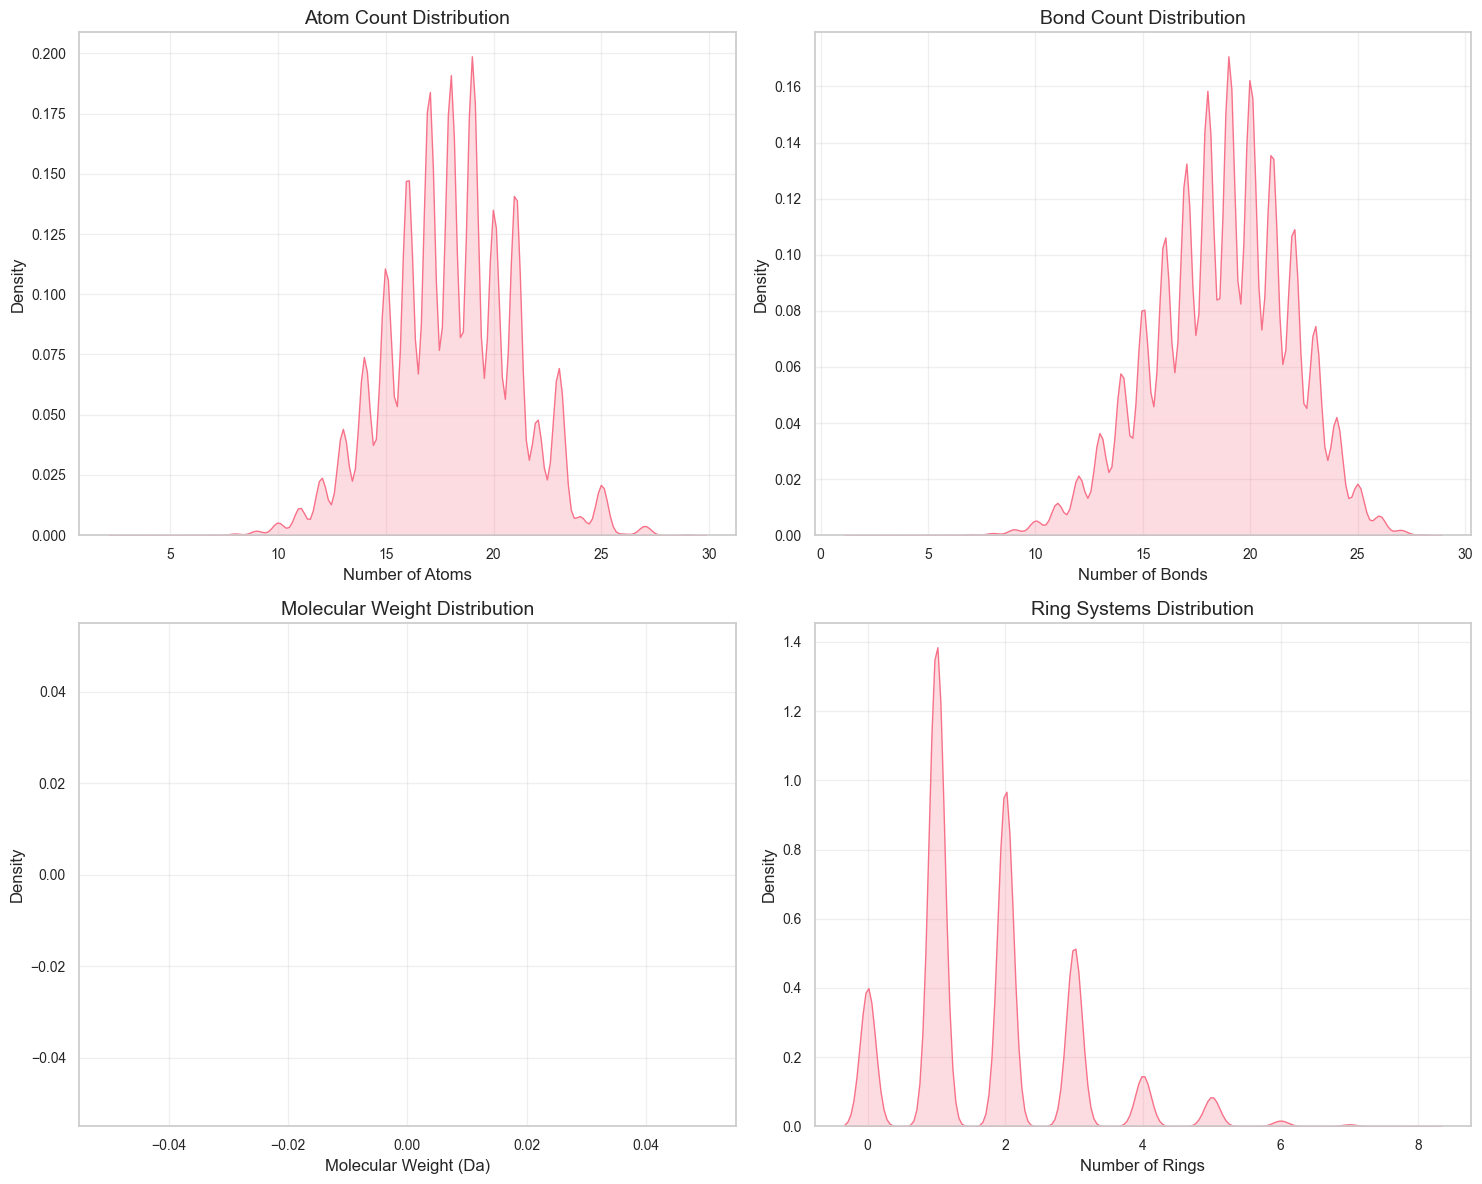

C:\Users\friha\AppData\Local\Temp\ipykernel_3500\1712449619.py:25: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(lengths, label=f'Bond Type {bt}', fill=True)
C:\Users\friha\AppData\Local\Temp\ipykernel_3500\1712449619.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


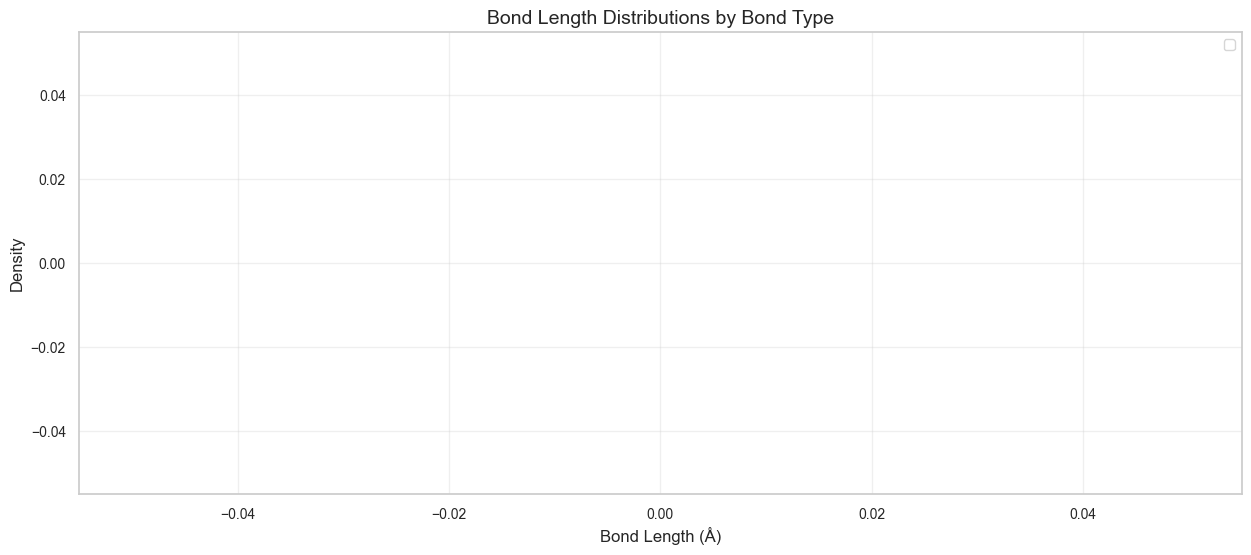

In [23]:
# Molecular size distributions
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
sns.kdeplot(mol_df['num_atoms'], ax=ax[0,0], fill=True)
ax[0,0].set_title('Atom Count Distribution')
ax[0,0].set_xlabel('Number of Atoms')

sns.kdeplot(mol_df['num_bonds'], ax=ax[0,1], fill=True)
ax[0,1].set_title('Bond Count Distribution')
ax[0,1].set_xlabel('Number of Bonds')

sns.kdeplot(mol_df['mol_weight'], ax=ax[1,0], fill=True)
ax[1,0].set_title('Molecular Weight Distribution')
ax[1,0].set_xlabel('Molecular Weight (Da)')

sns.kdeplot(mol_df['ring_systems'], ax=ax[1,1], fill=True)
ax[1,1].set_title('Ring Systems Distribution')
ax[1,1].set_xlabel('Number of Rings')

plt.tight_layout()
plt.show()

# Bond length analysis
fig = plt.figure(figsize=(15, 6))
for i, (bt, lengths) in enumerate(bond_lengths.items()):
    sns.kdeplot(lengths, label=f'Bond Type {bt}', fill=True)
plt.title('Bond Length Distributions by Bond Type')
plt.xlabel('Bond Length (Å)')
plt.legend()
plt.show()

## 3. Chemical Space Visualization
### High-dimensional embedding of molecular properties

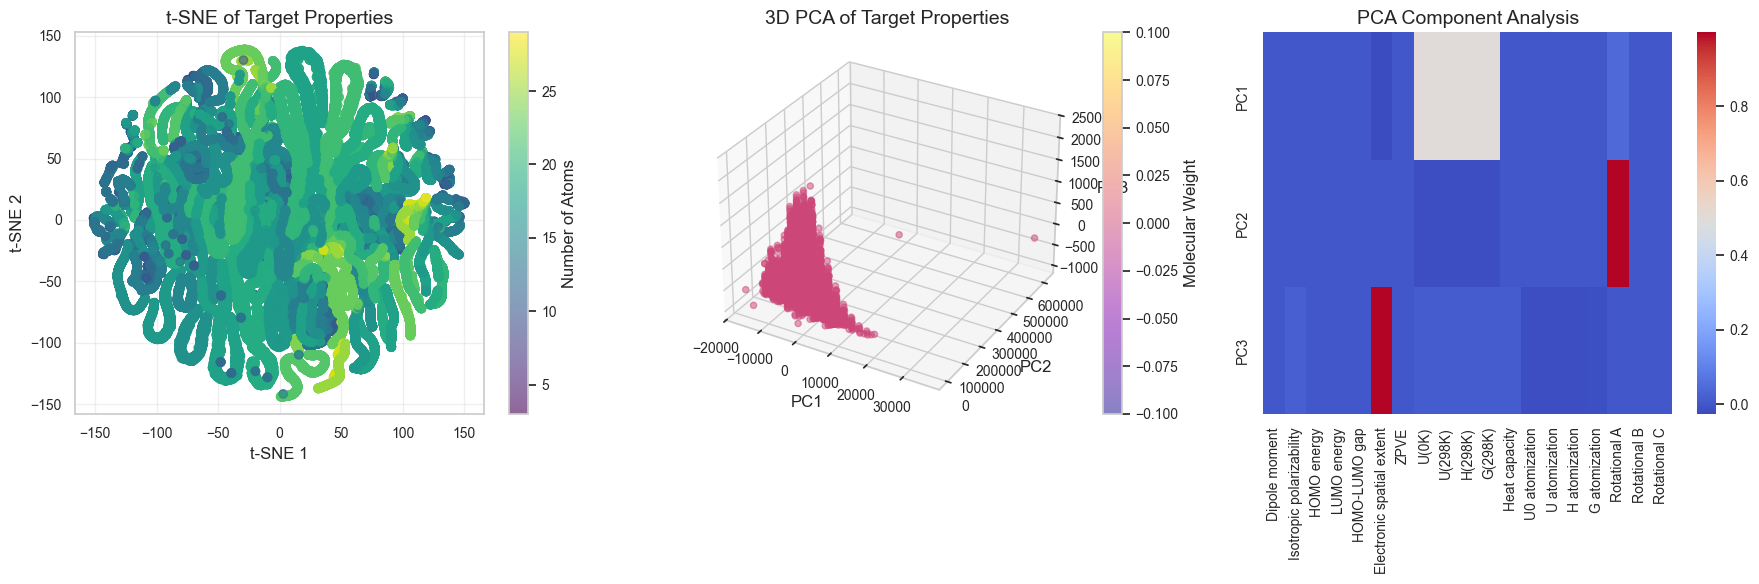

In [25]:
property_names = [
    'Dipole moment', 'Isotropic polarizability', 'HOMO energy',
    'LUMO energy', 'HOMO-LUMO gap', 'Electronic spatial extent',
    'ZPVE', 'U(0K)', 'U(298K)', 'H(298K)', 'G(298K)', 'Heat capacity',
    'U0 atomization', 'U atomization', 'H atomization', 'G atomization',
    'Rotational A', 'Rotational B', 'Rotational C'
]
# Plotting
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131)
scatter = ax1.scatter(tsne_results[:,0], tsne_results[:,1], 
                     c=mol_df['num_atoms'], cmap='viridis', alpha=0.6)
ax1.set_title('t-SNE of Target Properties')
ax1.set_xlabel('t-SNE 1')
ax1.set_ylabel('t-SNE 2')
plt.colorbar(scatter, label='Number of Atoms')

ax2 = fig.add_subplot(132, projection='3d')
sc = ax2.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2],
                c=mol_df['mol_weight'], cmap='plasma', alpha=0.5)
ax2.set_title('3D PCA of Target Properties')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
plt.colorbar(sc, label='Molecular Weight')

ax3 = fig.add_subplot(133)
sns.heatmap(pca.components_, cmap='coolwarm',
           yticklabels=['PC1','PC2','PC3'],
           xticklabels=property_names)
ax3.set_title('PCA Component Analysis')
ax3.set_xticklabels(property_names, rotation=90)

plt.tight_layout()
plt.show()

## 4. Graph Theoretical Analysis
### Advanced analysis of graph structure properties

Graph Analysis:   3%|▎         | 33/1000 [00:11<05:08,  3.14it/s]c:\Users\friha\.conda\envs\NetSci\lib\site-packages\networkx\algorithms\smallworld.py:310: RuntimeWarning: invalid value encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
Graph Analysis:  57%|█████▋    | 574/1000 [03:48<03:11,  2.23it/s]c:\Users\friha\.conda\envs\NetSci\lib\site-packages\networkx\algorithms\smallworld.py:310: RuntimeWarning: divide by zero encountered in scalar divide
  sigma = (C / Cr) / (L / Lr)
Graph Analysis: 100%|██████████| 1000/1000 [06:38<00:00,  2.51it/s]


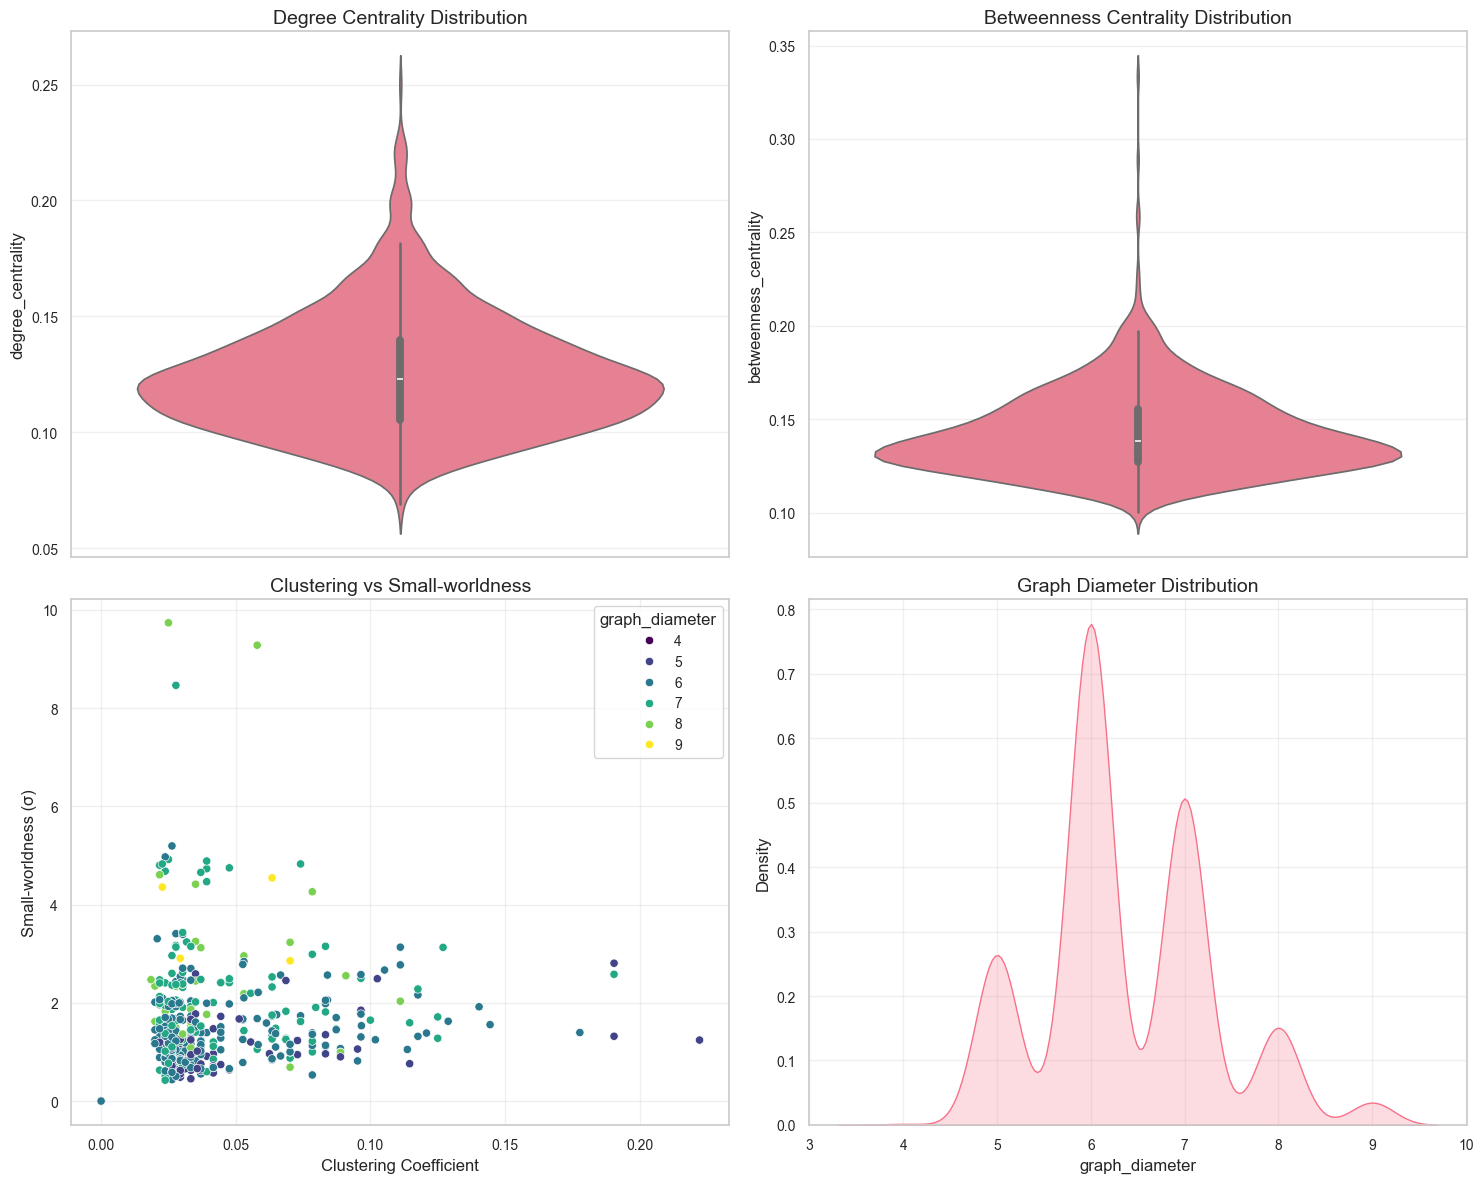

In [9]:
# Graph metrics calculation
graph_metrics = {
    'degree_centrality': [],
    'betweenness_centrality': [],
    'clustering_coeff': [],
    'graph_diameter': [],
    'small_worldness': []
}

sample_indices = np.random.choice(len(dataset), 1000, replace=False)
for idx in tqdm(sample_indices, desc='Graph Analysis'):
    data = dataset[idx]
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    edges = data.edge_index.t().numpy()
    G.add_edges_from(edges)
    
    # Degree centrality
    degree_cent = np.mean(list(nx.degree_centrality(G).values()))
    graph_metrics['degree_centrality'].append(degree_cent)
    
    # Betweenness centrality
    between_cent = np.mean(list(nx.betweenness_centrality(G).values()))
    graph_metrics['betweenness_centrality'].append(between_cent)
    
    # Clustering coefficient
    clust_coeff = nx.average_clustering(G)
    graph_metrics['clustering_coeff'].append(clust_coeff)
    
    # Graph diameter
    try:
        diam = nx.diameter(G)
    except:
        diam = np.nan
    graph_metrics['graph_diameter'].append(diam)
    
    # Small-worldness
    sigma = nx.sigma(G, niter=5)
    graph_metrics['small_worldness'].append(sigma)

graph_df = pd.DataFrame(graph_metrics)

# Plot graph metrics
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
sns.violinplot(y=graph_df['degree_centrality'], ax=ax[0,0])
ax[0,0].set_title('Degree Centrality Distribution')

sns.violinplot(y=graph_df['betweenness_centrality'], ax=ax[0,1])
ax[0,1].set_title('Betweenness Centrality Distribution')

sns.scatterplot(x=graph_df['clustering_coeff'], y=graph_df['small_worldness'],
               hue=graph_df['graph_diameter'], ax=ax[1,0], palette='viridis')
ax[1,0].set_title('Clustering vs Small-worldness')
ax[1,0].set_xlabel('Clustering Coefficient')
ax[1,0].set_ylabel('Small-worldness (σ)')

sns.kdeplot(graph_df['graph_diameter'], ax=ax[1,1], fill=True)
ax[1,1].set_title('Graph Diameter Distribution')

plt.tight_layout()
plt.show()


## 5. Quantum Chemical Property Correlations
### Advanced correlation analysis with statistical testing

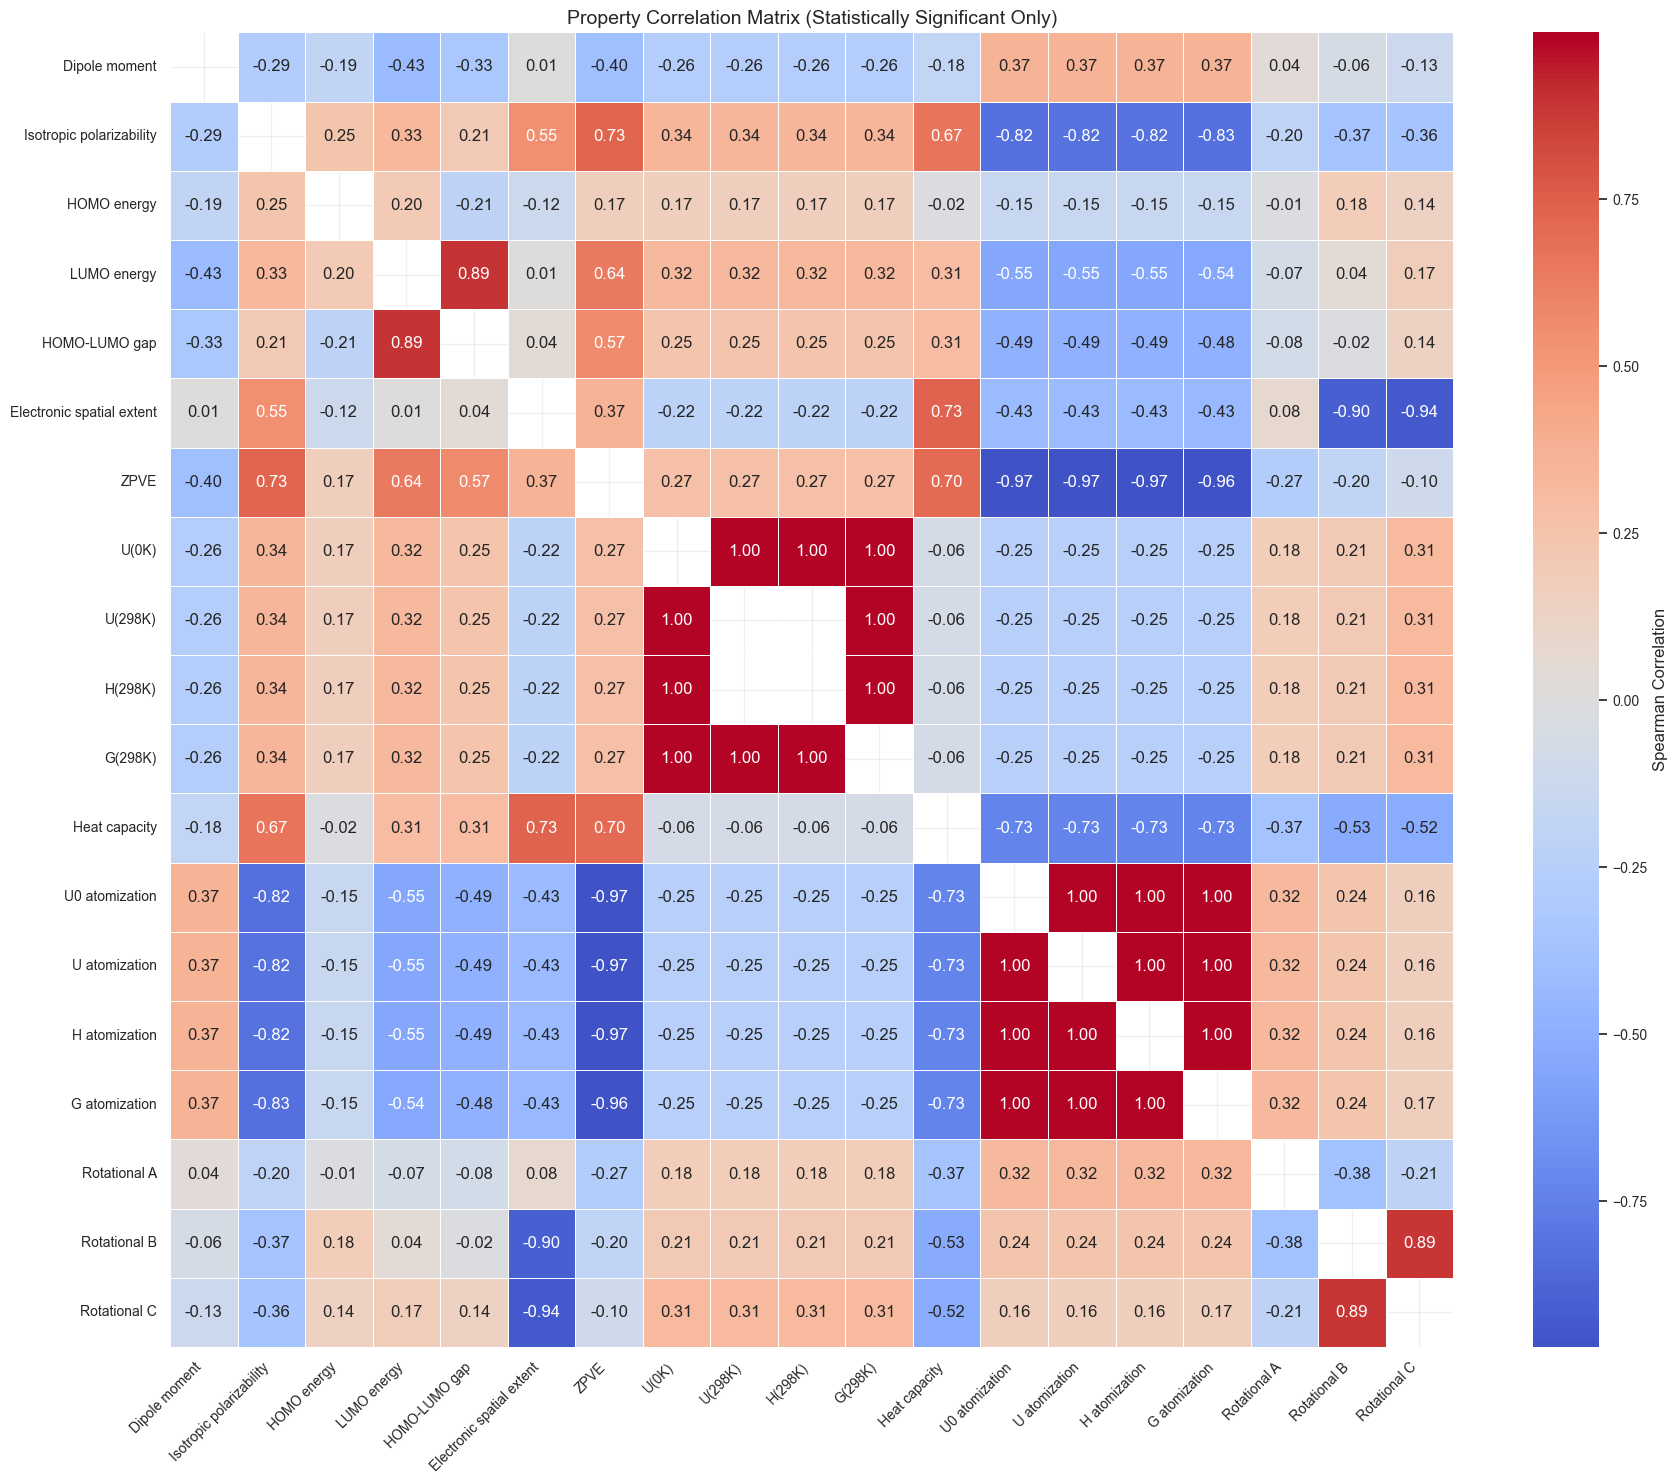

In [27]:
# Correlation matrix with statistical significance
target_df = pd.DataFrame(targets, columns=property_names)
corr_matrix = target_df.corr(method='spearman')

# Mask for statistical significance
p_values = np.zeros_like(corr_matrix)
for i in range(len(property_names)):
    for j in range(len(property_names)):
        _, p_values[i,j] = kstest(target_df.iloc[:,i], target_df.iloc[:,j])

mask = p_values > 0.05  # Not statistically significant

# Plot correlation matrix
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0,
           annot=True, fmt=".2f", linewidths=.5,
           cbar_kws={'label': 'Spearman Correlation'})
plt.title('Property Correlation Matrix (Statistically Significant Only)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Molecular Scaffold Analysis
### Chemical pattern discovery using RDKit

Scaffold Analysis:  39%|███▉      | 392/1000 [00:00<00:00, 1439.17it/s][07:02:29] Explicit valence for atom # 2 C, 5, is greater than permitted
[07:02:29] Explicit valence for atom # 2 C, 5, is greater than permitted
Scaffold Analysis:  66%|██████▌   | 656/1000 [00:00<00:00, 1907.86it/s][07:02:29] Explicit valence for atom # 2 C, 5, is greater than permitted
[07:02:29] Explicit valence for atom # 2 C, 5, is greater than permitted
Scaffold Analysis: 100%|██████████| 1000/1000 [00:00<00:00, 1743.35it/s]
C:\Users\friha\AppData\Local\Temp\ipykernel_3500\127476727.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_scaffolds.values, y=top_scaffolds.index, palette='viridis')


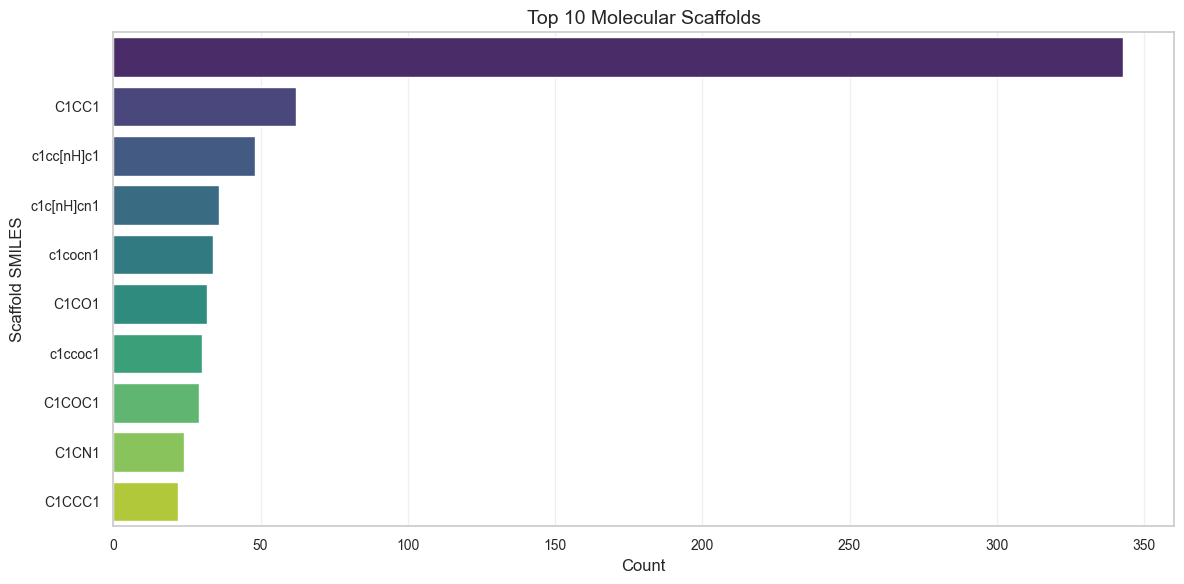

In [28]:
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Scaffold analysis
scaffold_stats = {
    'scaffold_class': [],
    'complexity': [],
    'num_rotatable_bonds': [],
    'num_aromatic_rings': []
}

for data in tqdm(dataset[:1000], desc='Scaffold Analysis'):  # Subsample for speed
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        scaffold_stats['scaffold_class'].append(
            MurckoScaffold.MurckoScaffoldSmiles(mol=scaffold)
        )
        scaffold_stats['complexity'].append(
            Descriptors.MolWt(scaffold)/Descriptors.MolWt(mol)
        )
        scaffold_stats['num_rotatable_bonds'].append(
            Descriptors.NumRotatableBonds(mol)
        )
        scaffold_stats['num_aromatic_rings'].append(
            Descriptors.NumAromaticRings(mol)
        )

scaffold_df = pd.DataFrame(scaffold_stats)

# Scaffold diversity analysis
top_scaffolds = scaffold_df['scaffold_class'].value_counts().nlargest(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_scaffolds.values, y=top_scaffolds.index, palette='viridis')
plt.title('Top 10 Molecular Scaffolds')
plt.xlabel('Count')
plt.ylabel('Scaffold SMILES')
plt.tight_layout()
plt.show()

## 7. 3D Geometry Analysis
### Spatial distribution of atomic coordinates

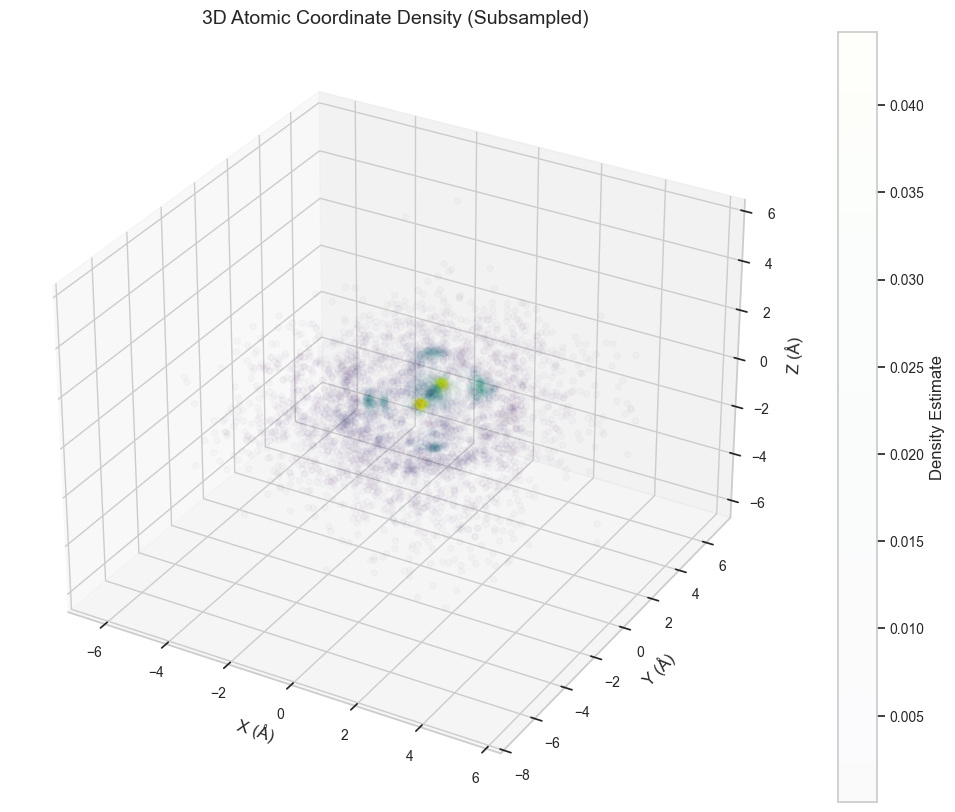

In [13]:
# 3D coordinate analysis
import random # Import random module

# --- Subsampling for efficiency ---
num_molecules_for_3d = 1000  # Reduce this number if it's still slow
random_indices = random.sample(range(len(dataset)), num_molecules_for_3d)
subset_dataset = [dataset[i] for i in random_indices]

all_pos_subset = torch.cat([data.pos for data in subset_dataset]).numpy()


# Kernel Density Estimation
xyz_subset = all_pos_subset.T
kde_subset = gaussian_kde(xyz_subset)(xyz_subset)

# 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Subsampling points for plotting (optional, if still slow) ---
points_to_plot = 5000 # Reduce this number further if needed
if kde_subset.size > points_to_plot:
    plot_indices = random.sample(range(kde_subset.size), points_to_plot)
    x_plot = xyz_subset[0][plot_indices]
    y_plot = xyz_subset[1][plot_indices]
    z_plot = xyz_subset[2][plot_indices]
    kde_plot = kde_subset[plot_indices]
else:
    x_plot = xyz_subset[0]
    y_plot = xyz_subset[1]
    z_plot = xyz_subset[2]
    kde_plot = kde_subset


sc = ax.scatter(x_plot, y_plot, z_plot, c=kde_plot, cmap='viridis', alpha=0.02) # Use the subset data
ax.set_title('3D Atomic Coordinate Density (Subsampled)') # Modified title to indicate subsampling
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
plt.colorbar(sc, label='Density Estimate')
plt.show()

Sampling coordinates: 100%|██████████| 1000/1000 [00:00<00:00, 28762.98it/s]


Number of molecules sampled: 1000
Shape of first position array: (20, 3)
Shape of xyz array: (3, 17887)
Maximum density in histogram: 682.0
Threshold value: 6.82
Number of bins above threshold: 401
X range: -7.3894 5.854
Y range: -7.2826 6.8721
Z range: -6.6913 6.5428
Edges (first dimension, first 5): [-7.38940001 -7.058315   -6.72723    -6.396145   -6.06506   ]

--- Shape Debugging Before Scatter Plot ---
Shape of hist: (40, 40, 40)
Shape of mask: (40, 40, 40)
Shape of hist[mask]: (401,)
Shape of X[mask]: (401,)
Shape of Y[mask]: (401,)
Shape of Z[mask]: (401,)


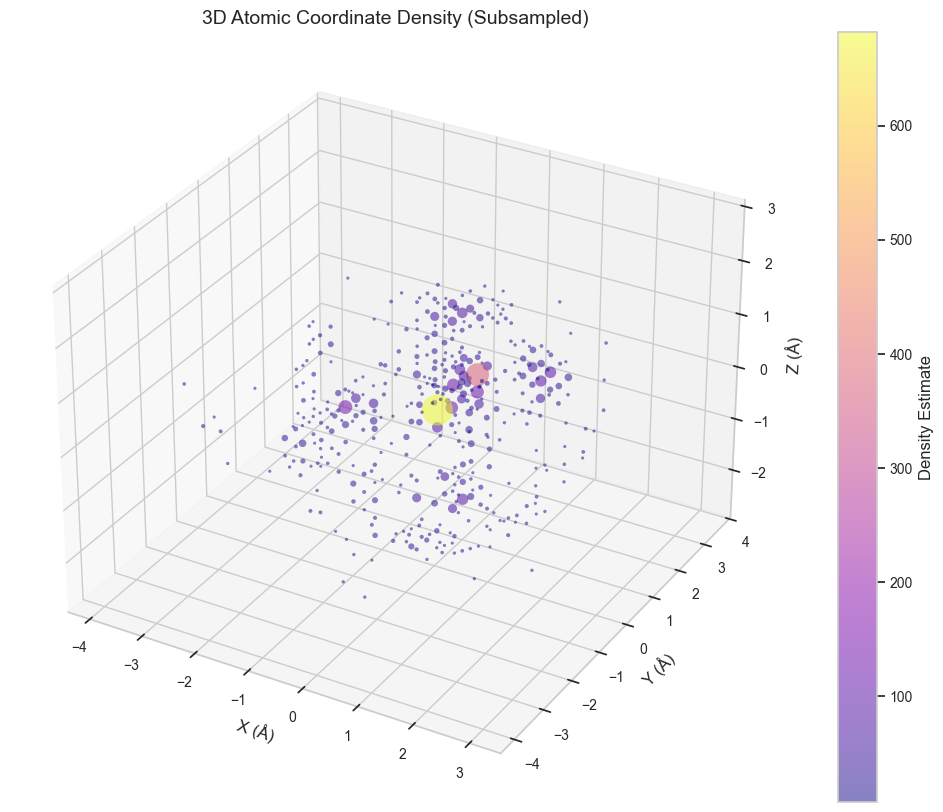

In [20]:
# 3D coordinate analysis
import random # Import random module

# --- Subsampling for efficiency ---
num_molecules_for_3d = 1000  # Reduce this number if it's still slow
random_indices = random.sample(range(len(dataset)), num_molecules_for_3d)
subset_dataset = [dataset[i] for i in random_indices]

all_pos_subset = torch.cat([data.pos for data in subset_dataset]).numpy()

positions = [] # Define positions list here, before the loop
for idx in tqdm(random_indices, desc='Sampling coordinates'): # Corrected variable name in loop: random_indices
    positions.append(dataset[idx].pos.numpy())
xyz_subset = all_pos_subset.T
kde_subset = gaussian_kde(xyz_subset)(xyz_subset)


# Debugging Prints (Step 1 & 2 - as before)
print(f"Number of molecules sampled: {len(positions)}")
if positions:
    print(f"Shape of first position array: {positions[0].shape}")
else:
    print("Error: No positions were sampled! Check dataset and indices.")
print(f"Shape of xyz array: {xyz_subset.shape}")

hist, edges = np.histogramdd(xyz_subset.T, bins=40) # bins=40 (Reduced bins)
max_density = hist.max()
threshold = 0.01 * max_density # threshold = 0.01 (Increased threshold multiplier)

print(f"Maximum density in histogram: {max_density}")
print(f"Threshold value: {threshold}")
mask = hist > threshold
print(f"Number of bins above threshold: {np.sum(mask)}")

# Debugging Prints (Step 4 - Data Ranges - as before)
print("X range:", xyz_subset[0].min(), xyz_subset[0].max())
print("Y range:", xyz_subset[1].min(), xyz_subset[1].max())
print("Z range:", xyz_subset[2].min(), xyz_subset[2].max())
print("Edges (first dimension, first 5):", edges[0][:5])

# Grid creation for nonzero bins
x_centers = (edges[0][:-1] + edges[0][1:])/2
y_centers = (edges[1][:-1] + edges[1][1:])/2
z_centers = (edges[2][:-1] + edges[2][1:])/2
X, Y, Z = np.meshgrid(x_centers, y_centers, z_centers, indexing='ij')

mask = hist > threshold

# --- Debugging SHAPES right before scatter plot ---
print("\n--- Shape Debugging Before Scatter Plot ---")
print(f"Shape of hist: {hist.shape}")
print(f"Shape of mask: {mask.shape}")
print(f"Shape of hist[mask]: {hist[mask].shape}") # Shape of color data
print(f"Shape of X[mask]: {X[mask].shape}")       # Shape of x_plot
print(f"Shape of Y[mask]: {Y[mask].shape}")       # Shape of y_plot
print(f"Shape of Z[mask]: {Z[mask].shape}")       # Shape of z_plot


# 3D plot
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Subsampling points for plotting (optional, if still slow) ---
points_to_plot = 5000 # Reduce this number further if needed
if kde_subset.size > points_to_plot: # This part is actually not needed anymore with histogram approach, can remove for simplicity
    plot_indices = random.sample(range(kde_subset.size), points_to_plot) # KDE is not used anymore, remove this
    x_plot = xyz_subset[0][plot_indices] # Remove KDE related code here
    y_plot = xyz_subset[1][plot_indices]
    z_plot = xyz_subset[2][plot_indices]
    kde_plot = kde_subset[plot_indices] # Remove KDE related code here
else:
    x_plot = xyz_subset[0] # Remove KDE related code here
    y_plot = xyz_subset[1]
    z_plot = xyz_subset[2]
    kde_plot = kde_subset # Remove KDE related code here


x_plot = X[mask] # Use histogram grid centers directly
y_plot = Y[mask]
z_plot = Z[mask]
kde_plot = hist[mask] # Use histogram values as color data

sc = ax.scatter(x_plot, y_plot, z_plot, c=kde_plot, cmap='plasma', alpha=0.5, s=500 * kde_plot/max_density, edgecolor='none') # alpha=0.5, s=500 for extreme visibility
ax.set_title('3D Atomic Coordinate Density (Subsampled)') # Modified title to indicate subsampling
ax.set_xlabel('X (Å)')
ax.set_ylabel('Y (Å)')
ax.set_zlabel('Z (Å)')
plt.colorbar(sc, label='Density Estimate')
plt.show()




## 8. Intermolecular Similarity Analysis
### Advanced similarity metrics using molecular fingerprints

Fingerprinting:   0%|          | 0/1000 [00:00<?, ?it/s][07:23:11] Explicit valence for atom # 1 C, 5, is greater than permitted
[07:23:11] Explicit valence for atom # 1 C, 5, is greater than permitted
Fingerprinting:  32%|███▏      | 323/1000 [00:00<00:00, 3227.95it/s][07:23:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[07:23:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[07:23:11] Explicit valence for atom # 2 C, 5, is greater than permitted
[07:23:11] Explicit valence for atom # 2 C, 5, is greater than permitted
Calculating Similarities: 100%|██████████| 1000/1000 [00:02<00:00, 347.07it/s]


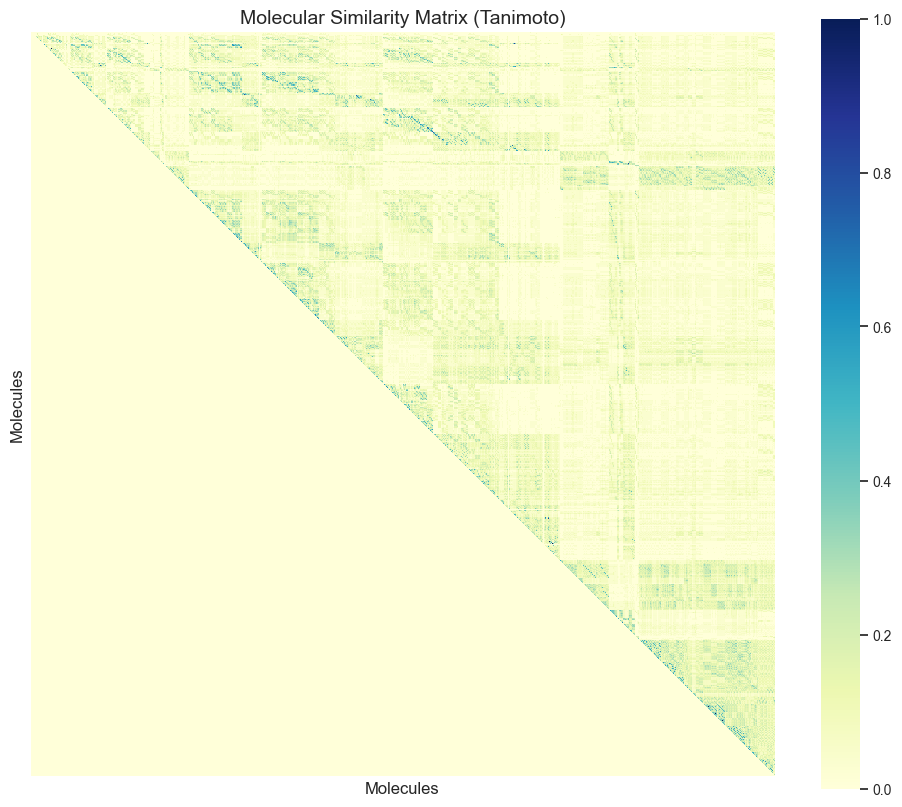

In [10]:
from rdkit import DataStructs
from rdkit.Chem import AllChem

# Generate fingerprints
fps = []
for data in tqdm(dataset[:1000], desc='Fingerprinting'):  # Subsample
    mol = Chem.MolFromSmiles(data.smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        fps.append(fp)
    else:
        fps.append(None)

# Similarity matrix
similarity = np.zeros((len(fps), len(fps)))
for i in tqdm(range(len(fps)), desc='Calculating Similarities'):
    for j in range(i+1, len(fps)):
        if fps[i] and fps[j]:
            similarity[i,j] = DataStructs.TanimotoSimilarity(fps[i], fps[j])
            
# Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(similarity, cmap='YlGnBu', square=True, 
           xticklabels=False, yticklabels=False)
plt.title('Molecular Similarity Matrix (Tanimoto)')
plt.xlabel('Molecules')
plt.ylabel('Molecules')

plt.show()